In [1]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog, Label, Button, Entry
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

import ipywidgets as widgets

from itertools import combinations, product

import random

from collections import Counter

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def see(img):
    plt.imshow(img)

In [3]:
def get_dominant_colors(img, k=4, rounds=1):
    pixels = img.reshape(-1, 3).astype(np.float32)
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(np.uint8)
    return colors

In [4]:
def auto_white_balance(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    avg_a = np.mean(a)
    avg_b = np.mean(b)
    
    a = a - ((avg_a - 128) * (l / 255.0) * 1.1)
    b = b - ((avg_b - 128) * (l / 255.0) * 1.1)
    
    a = np.clip(a, 0, 255).astype(np.uint8)
    b = np.clip(b, 0, 255).astype(np.uint8)
    
    balanced_lab = cv2.merge([l, a, b])
    return cv2.cvtColor(balanced_lab, cv2.COLOR_LAB2BGR)

In [5]:
def pdistance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

In [6]:
def check_aspect_ratio(corners, expected_ratio=1.5, tolerance=0.2):
    """Check for 3:2 (or 2:3) side ratio"""
    sides = sorted([
        pdistance(corners[0], corners[1]),
        pdistance(corners[1], corners[2]),
        pdistance(corners[2], corners[3]),
        pdistance(corners[3], corners[0])
    ])
    ratio = sides[3] / sides[0] if sides[0] != 0 else float('inf')
    return abs(ratio - expected_ratio) <= tolerance

In [7]:
def get_contours_by_mask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_cnt = None
    C = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 30:
            C.append(cnt)
            # peri = cv2.arcLength(cnt, True)
            # approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            # if len(approx) == 4:  # Ищем четырехугольники
            #     if area > max_area:
            #         max_area = area
            #         best_cnt = approx
    
    print(len(C))
    return C

In [8]:
def get_contours_by_mask_new(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_cnt = None
    C = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 30:
            C.append(cnt)
            # peri = cv2.arcLength(cnt, True)
            # approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            # if len(approx) == 4:  # Ищем четырехугольники
            #     if area > max_area:
            #         max_area = area
            #         best_cnt = approx
    
    print(len(C))
    return C

In [9]:
def is_cont_closed(cnt, threshold=5):
    start = cnt[0][0]
    end = cnt[-1][0]
    dist = np.linalg.norm(start - end)
    return dist < threshold

In [10]:
def show_contours(image, contours, thickness=2):
    cv2.drawContours(image, contours, -1, (255, 0, 0), thickness)

In [11]:
def point_to_line_distance(line, point):
    x1, y1, x2, y2 = line
    px, py = point
    numerator = abs((y2 - y1)*px - (x2 - x1)*py + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

In [12]:
def draw_lines(image, lines, color, thickness=5):
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(image, (x1, y1), (x2, y2), color, thickness)

In [13]:
def langle(line):
    x1, y1, x2, y2 = line
    return np.degrees(np.atan2(y2 - y1, x2 - x1))

In [14]:
def line_polar_coords(line):
    x1, y1, x2, y2 = line
    angle = langle(line) % 180
    vx, vy = x2 - x1, y2 - y1
    norm = np.hypot(vx, vy)
    nx, ny = -vy / norm, vx / norm
    midx, midy = (x1 + x2) / 2, (y1 + y2) / 2
    rho = midx * nx + midy * ny
    return angle, rho

In [15]:
def cluster_lines_by_angle(lines, angle_threshold=10):
    clusters = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = langle(line[0])
        #print(f"[DEBUG]langle = {angle}")

        added = False
        for cluster in clusters:
            cluster_angle = cluster['angle']
            # print(f"[INSIDE] cluster_angle = {cluster_angle}")
            if abs(angle - cluster_angle) < angle_threshold:
                cluster['lines'].append((x1, y1, x2, y2))
                cluster['angles'].append(angle)
                added = True
                break

        if not added:
            clusters.append({
                'angle': angle,
                'lines': [(x1, y1, x2, y2)],
                'angles': [angle]
            })

    for cluster in clusters:
        cluster['angle'] = np.mean(cluster['angles'])

    return clusters

In [16]:
def cluster_lines_by_polar_coords(lines, angle_threshold=10, rho_threshold=20):
    clusters = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle_deg, rho = line_polar_coords(line[0])
        angle_rad = np.radians(angle_deg)

        added = False
        for cluster in clusters:
            cluster_angle = cluster['angle']
            cluster_rho = cluster['rho']

            if abs(angle_deg - cluster_angle) < angle_threshold and abs(rho - cluster_rho) < rho_threshold:
                cluster['lines'].append((x1, y1, x2, y2))
                cluster['angles'].append(angle_deg)
                cluster['rhos'].append(rho)
                added = True
                break

        if not added:
            clusters.append({
                'angle': angle_deg,
                'rho': rho,
                'lines': [(x1, y1, x2, y2)],
                'angles': [angle_deg],
                'rhos': [rho]
            })

    for cluster in clusters:
        cluster['angle'] = np.mean(cluster['angles'])
        cluster['rho'] = np.mean(cluster['rhos'])

    return clusters

In [17]:
def trapezoid_s_and_h(segment1, segment2, angle_tolerance=5):
    """
    Вычисляет площадь и высоту между двумя параллельными отрезками,
    даже если их проекции не перекрываются.
    Возвращает (0, 0) для непараллельных отрезков.
    """
    try:
        A = np.array([segment1[0], segment1[1]])
        B = np.array([segment1[2], segment1[3]])
        C = np.array([segment2[0], segment2[1]])
        D = np.array([segment2[2], segment2[3]])

        dir1 = B - A
        dir2 = D - C

        norm1 = np.linalg.norm(dir1)
        norm2 = np.linalg.norm(dir2)
        if norm1 < 1e-6 or norm2 < 1e-6:
            return 0.0, 0.0

        dir1_norm = dir1 / norm1
        dir2_norm = dir2 / norm2

        cos_angle = np.dot(dir1_norm, dir2_norm)
        angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))

        if angle > angle_tolerance and angle < (180 - angle_tolerance):
            return 0.0, 0.0

        if angle > 90:
            dir2_norm *= -1
            dir2 = dir2_norm * norm2

        avg_dir = (dir1_norm + dir2_norm) / 2
        avg_dir /= np.linalg.norm(avg_dir)

        normal = np.array([-avg_dir[1], avg_dir[0]])
        normal_norm = normal / np.linalg.norm(normal)

        AC = C - A
        h = abs(np.dot(AC, normal_norm))

        len1 = abs(np.dot(B - A, avg_dir))
        len2 = abs(np.dot(D - C, avg_dir))

        area = 0.5 * (len1 + len2) * h

        return area, h

    except Exception as e:
        print(f"Error: {str(e)}")
        return 0.0, 0.0

In [18]:
def line_to_line_distance(segment1, segment2, angle_tolerance=5):
    """
    Вычисляет высоту между двумя почти параллельными отрезками
    Возвращает 0.0 для непараллельных отрезков
    """
    try:
        A = np.array(segment1[:2])
        B = np.array(segment1[2:])
        C = np.array(segment2[:2])
        D = np.array(segment2[2:])
        
        dir1 = B - A
        dir2 = D - C
        
        norm1 = np.linalg.norm(dir1)
        norm2 = np.linalg.norm(dir2)
        if norm1 < 1e-6 or norm2 < 1e-6:
            return 0.0
        
        dir1_norm = dir1 / norm1
        dir2_norm = dir2 / norm2
        
        cos_angle = np.dot(dir1_norm, dir2_norm)
        angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
        
        if angle > angle_tolerance and angle < (180 - angle_tolerance):
            return 0.0
        
        if angle > 90:
            dir2_norm *= -1
        
        avg_dir = (dir1_norm + dir2_norm) / 2
        avg_dir /= np.linalg.norm(avg_dir)
        
        normal = np.array([-avg_dir[1], avg_dir[0]])
        normal_norm = normal / np.linalg.norm(normal)
        
        AC = C - A
        h = abs(np.dot(AC, normal_norm))
        
        return h
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return 0.0

In [19]:
def gypsy_pairs(clusters):
    """
    lets assume that card has 3:2 side ratio
    Hence, ((l1+l2)**2)/6 <= S <= 6x**2
    """
    pairs = []
    distances = []
    for cluster_id, cluster in enumerate(clusters):
        lines = cluster['lines']
        if len(lines) < 2:
            continue
            
        lengths = [pdistance((x1, y1), (x2, y2)) for x1, y1, x2, y2 in lines]
        
        sorted_lengths = sorted(lengths)
        l1_min, l2_min = sorted_lengths[:2]
        l1_max, l2_max = sorted_lengths[-2:]
        
        X = (l1_max + l2_max)/6
        S_min = ((l1_min + l2_min)**2)/6
        S_max = 6*X**2

        print(f"Cluster: {cluster_id}")
        print(f"S_min: {S_min}, S_max: {S_max}")
        print(f"X: {X}")
        print(f"l1_min, l2_min: {l1_min}, {l2_min}")
        print(f"l1_max, l2_max: {l1_max}, {l2_max}")
        
        for i in range(len(lines)):
            for j in range(i + 1, len(lines)):
                # h must be: h >= 2x
                s, h = trapezoid_s_and_h(lines[i], lines[j])
                if s == 0 or h < 2*X or not (S_min <= s <= S_max):
                    continue
                pairs.append((cluster_id, lines[i], lines[j], h))
                print(f"[INSIDE] cluster_id_{cluster_id}: s = {s}, h = {h}")
                distances.append(h)
    return pairs, distances

In [20]:
def get_all_rois(img, contours, max_cols=4, figsize=(12, 8)):
    n = len(contours)
    MIN_AREA = 100 * 150
    rois = []
    if n == 0:
        print("Нет контуров для отображения")
        return

    n_rows = (n + max_cols - 1) // max_cols
    n_cols = min(n, max_cols)
    
    plt.figure(figsize=figsize)
    
    for i, cont in enumerate(contours, 1):
        m = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(m, [cont], -1, 255, thickness=-1)
        masked_img = cv2.bitwise_and(img, img, mask=m)
        
        x, y, w, h = cv2.boundingRect(cont)
        roi = masked_img[y:y+h, x:x+w].copy()
        
        if len(roi.shape) == 3 and roi.shape[2] == 3:
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

        rh, rw = roi.shape[:2]
        if rh < 50 or h < 50:
            print("SMALL 1")
            continue
        elif rh * rw < MIN_AREA * 0.7:
            print("SMALL (AREA) 2")
            continue
        else:
            rois.append(roi)
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(roi)
        plt.axis('off')
        plt.title(f'ROI {i}')

    plt.tight_layout()
    plt.show()
    return rois

In [21]:
def show_all_centers(rois, max_cols=4, figsize=(12, 8)):
    n = len(rois)
    MIN_AREA = 100 * 150
    if len(rois) == 0:
        print("No ROIS")
        return
        
    n_rows = (n + max_cols - 1) // max_cols
    n_cols = min(n, max_cols)
    
    plt.figure(figsize=figsize)
    
    for i, r in enumerate(rois, 1):
        # check for size
        rh, rw = r.shape[:2]
        if rh < 50 or rh < 50:
            print("SMALL 1")
            continue

        if rh * rw < MIN_AREA * 0.7:
            print("SMALL (AREA) 2")
            continue

        
        r = auto_white_balance(r)
        gray = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        
        ##### get rid of hatching
        blur1 = cv2.GaussianBlur(gray, (3, 3), 0)
        blur2 = cv2.GaussianBlur(gray, (15, 15), 0)
        
        dog = cv2.subtract(blur1, blur2)
        dog = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)
        dog = dog.astype(np.uint8)
        #####
            
        # gray = cv2.GaussianBlur(gray, (5, 5), 0)
        
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(dog)

        ####
        mean, stddev = cv2.meanStdDev(enhanced)
        brightness = mean[0][0]
        contrast = stddev[0][0]

        print(f"{i}: [brightness:{brightness}, contrast:{contrast}]")
        
        if brightness < 100 and contrast < 50:
            print("UP ADN UP!")
            enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
        ####
        
        # enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
        # see(enhanced)
        
        enhanced = cv2.GaussianBlur(enhanced, (5, 5), 0)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        morph = cv2.morphologyEx(enhanced, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # see(morph)
        
        enhanced = morph
        
        i_c = r.copy()
        
        #####
        _, bin_mask = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        nn = cv2.Canny(bin_mask, 50, 150)
        contik, _ = cv2.findContours(nn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        show_contours(i_c, contik)
        contours = contik
        # nn = cv2.Canny(enhanced, 50, 150)
        # see(nn)
        # contours = get_contours_by_mask(nn)
        # show_contours(i_c, contours)
        # cv2.drawContours(i_c, contours, -1, 255, thickness=1)
        # see(i_c)
        
        i_test = r.copy()
        i_viz = r.copy()
        
        for c_t in contours:
            show_contours(i_test, c_t)
            # see(i_test)
            M = cv2.moments(c_t)
            if M["m00"] == 0:
                cx, cy = 0, 0
            else:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            
            points = c_t[:, 0, :]
            center = np.array([cx, cy])
            dists = np.linalg.norm(points - center, axis=1)
            
            for (x, y), d in zip(points, dists):
                cv2.circle(i_viz, (x, y), 1, (0, 255, 0), -1)
            
            cv2.circle(i_viz, (cx, cy), 4, (255, 0, 255), -1) # center
            # see(i_viz)
            # area = cv2.contourArea(c_t) 
            # perim = cv2.arcLength(c_t, True)
            # compactness = (perim ** 2) / (4 * np.pi * area + 1e-6)
            # print(f"perim {perim}, comp {compactness}")
            # approx = cv2.approxPolyDP(c_t, 0.01 * perim, True)
            # num_vertices = len(approx)
            # print(num_vertices)
            
            # is_convex = cv2.isContourConvex(c_t)
            # print(is_convex)
            # hull = cv2.convexHull(c_t)
            # show_contours(i_test, hull)
            # cv2.drawContours(i_test, [hull], -1, (0, 255, 0), 2)
            # see(i_test)
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(i_viz)
        plt.axis('off')
        plt.title(f'center {i}')
        
    plt.tight_layout()
    plt.show()

In [22]:
nums = [1, 2, 4, 6, 7, 9, 10]
image_selector = widgets.RadioButtons(
    options=[f'./images/IMG_{i}.jpg' for i in nums],
    description='Select Image:'
)

display(image_selector)

RadioButtons(description='Select Image:', options=('./images/IMG_1.jpg', './images/IMG_2.jpg', './images/IMG_4…

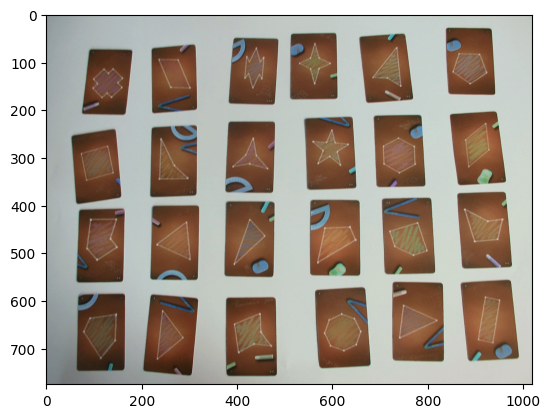

In [197]:
img = cv2.imread(image_selector.value)
img_orig = img.copy()
img = auto_white_balance(img)
# get_dominant_colors(img)
see(img)

# Найдем базовую маску (т.е. отделим карты от фона) BASED MASK

In [198]:
# lower and upper bound for "blue"
lower_blue = np.array([80, 40, 40])
upper_blue = np.array([130, 255, 255])
# mask for blue
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_blue, upper_blue)

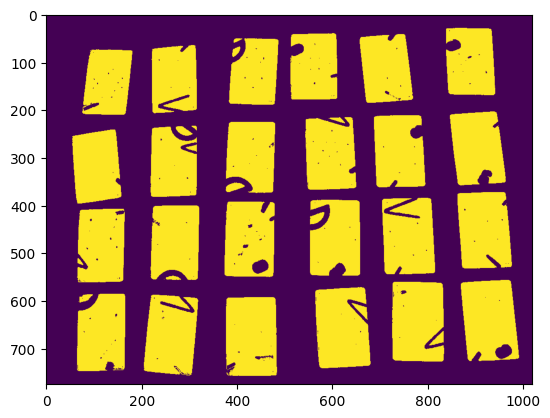

In [199]:
see(mask)

In [200]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
# mask = cv2.medianBlur(mask, 3)

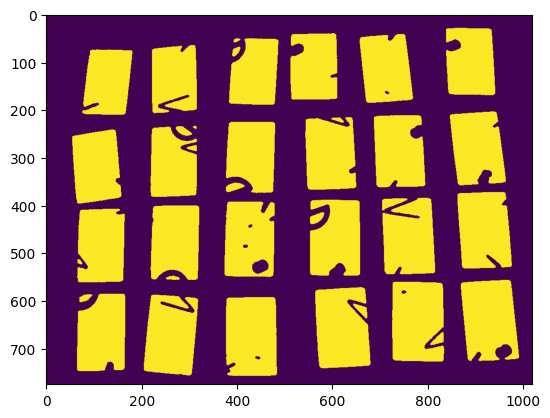

In [201]:
see(mask)

In [202]:
# TEST
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# mask = cv2.dilate(mask, kernel, iterations=2)
# mask = cv2.erode(mask, kernel, iterations=2)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# mask = cv2.dilate(mask, kernel, iterations=3)
# mask = cv2.erode(mask, kernel, iterations=3)

# dilate -> erode -> erode -> dilate
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
# 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# mask = cv2.dilate(mask, kernel, iterations=2)
# mask = cv2.erode(mask, kernel, iterations=3)

# mask = cv2.medianBlur(mask, 3)
# TEST

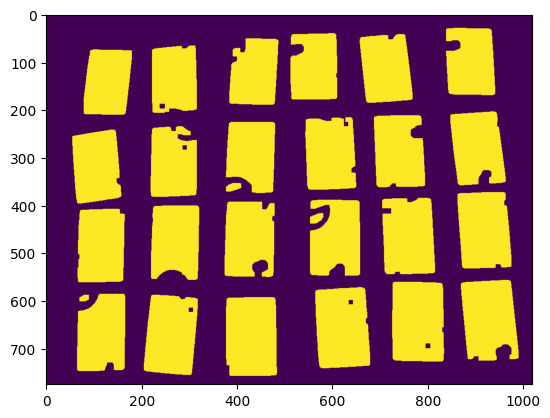

In [203]:
see(mask)

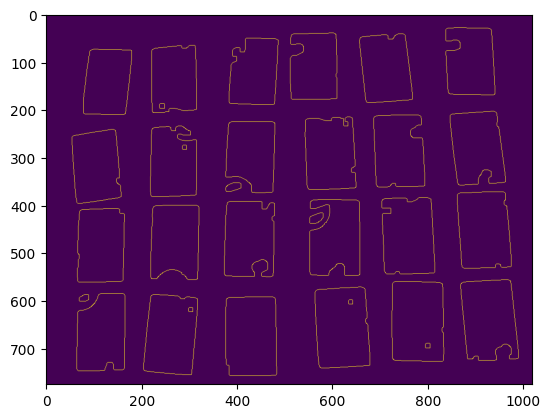

In [204]:
base_mask = mask
edges_base_mask = cv2.Canny(base_mask, 50, 150)
see(edges_base_mask)

# [exper] Попробуем WATERSHED для разделения "слипшихся карточек"

## 1st version (working)

In [205]:
ret, sure_fg = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
dist_transform = cv2.distanceTransform(sure_fg, cv2.DIST_L2, 5)

In [206]:
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

In [207]:
sure_bg = cv2.dilate(mask, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

[[-1 -1 -1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


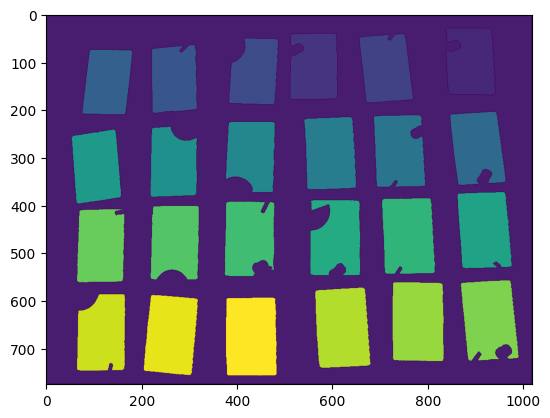

In [208]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
see(markers)
print(markers)

# 2nd version (testing...)

[[-1 -1 -1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


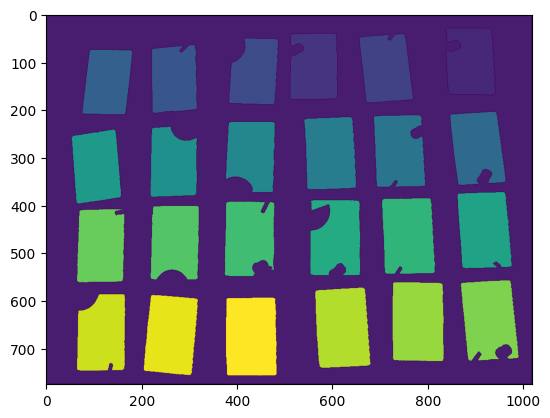

In [209]:
kernel = np.ones((5,5), np.uint8)
sure_bg = cv2.dilate(mask, kernel, iterations=3)
eroded = cv2.erode(mask, kernel, iterations=2)
dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)

see(markers)
print(markers)
print(eroded)

In [210]:
C = get_contours_by_mask(mask)

27


По 3 перпенд. прямым можно точно определить прямоугольник, храня сренднее зн. площади
если площадь `(s_mean - s[i]) / s_mean <= 0.3)` то все ок. Иначе средняя сторона -- точно $b$ (т.е. меньшая)

# Найдем контуры карточек

27


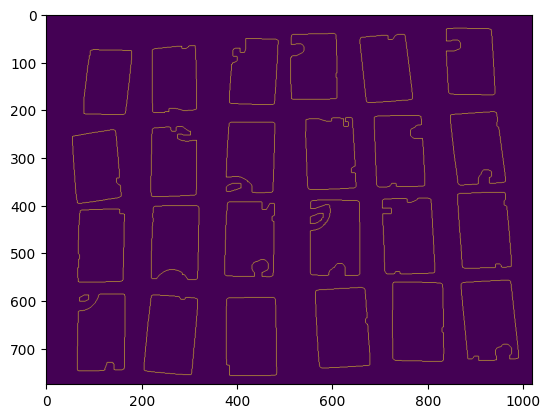

In [211]:
C = get_contours_by_mask(base_mask)
C_mask = np.zeros_like(base_mask)
cv2.drawContours(C_mask, C, -1, 255, thickness=1)
see(C_mask)

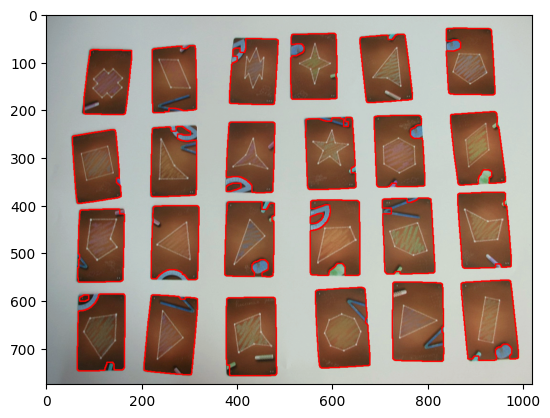

In [212]:
img_c = img.copy()
show_contours(img_c, C)
see(img_c)

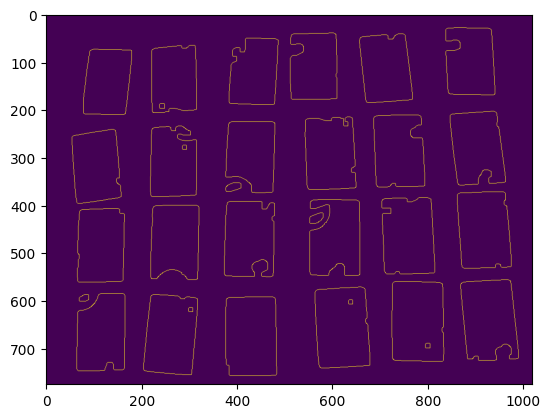

In [213]:
edges = cv2.Canny(base_mask, 50, 150)
# edges = cv2.Canny(C_mask, 50, 150)
see(edges)

# EXPER EXPER

In [214]:
def extract_figures_in_contour(image, cnt, min_area=50):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    # cv2.drawContours(mask, [cnt], -1, 255, -1)
    cv2.drawContours(mask, [cnt], -1, 255, thickness=1)

    inner = cv2.bitwise_and(image, image, mask=mask)
    gray = cv2.cvtColor(inner, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, bin_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    inner_contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output = image.copy()
    extracted = []

    for ic in inner_contours:
        area = cv2.contourArea(ic)
        if area < min_area:
            continue 

        if len(ic) >= 5:
            ellipse = cv2.fitEllipse(ic)
            (xc, yc), (w, h), angle = ellipse
            roi = extract_ellipse_patch(image, ellipse)
            extracted.append(roi)

            if visualize:
                cv2.ellipse(output, ellipse, (0, 255, 0), 2)
        else:
            x, y, w, h = cv2.boundingRect(ic)
            roi = image[y:y+h, x:x+w]
            extracted.append(roi)

    return extracted

In [215]:
ii = img_orig.copy()

SMALL 1
SMALL 1
SMALL 1


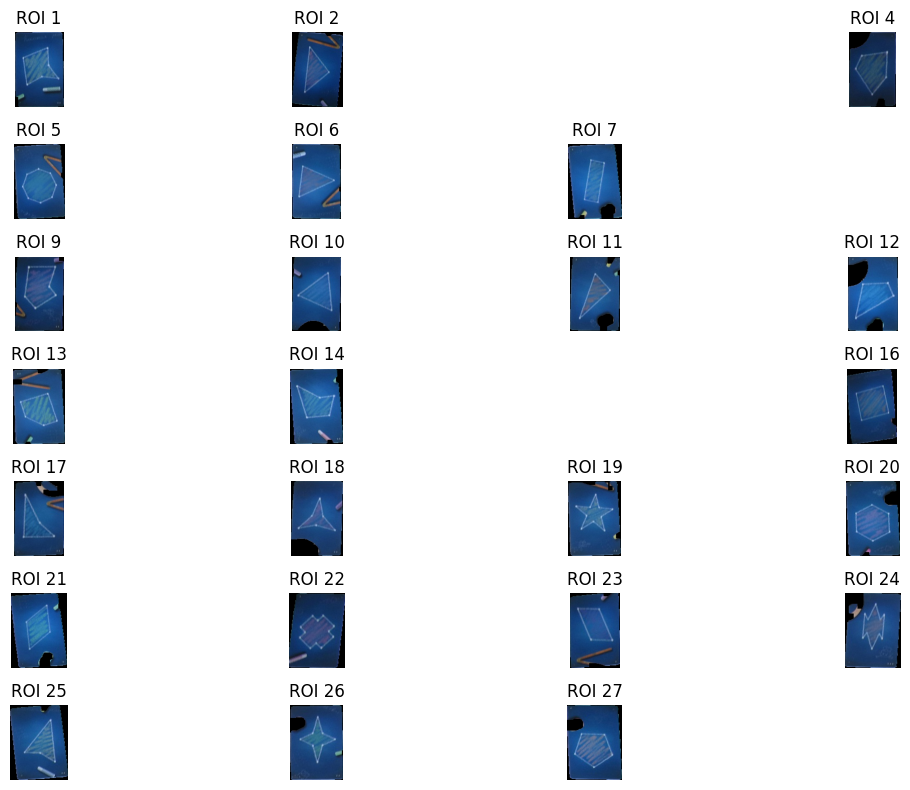

In [216]:
rois = get_all_rois(ii, C)

1: [brightness:15.674596431605776, contrast:28.449988471675905]
UP ADN UP!
2: [brightness:14.482511588706279, contrast:25.945086294642866]
UP ADN UP!
3: [brightness:14.216293851607384, contrast:25.424343326694625]
UP ADN UP!
4: [brightness:16.125882352941176, contrast:30.214184439713133]
UP ADN UP!
5: [brightness:16.6266000109872, contrast:31.327489215125386]
UP ADN UP!
6: [brightness:17.483495525453566, contrast:33.27634606709233]
UP ADN UP!
7: [brightness:17.21336744064017, contrast:29.747700413601542]
UP ADN UP!
8: [brightness:16.940847930946944, contrast:31.06779236049512]
UP ADN UP!
9: [brightness:15.963351416515975, contrast:27.620191308390137]
UP ADN UP!
10: [brightness:14.876190476190477, contrast:26.170149688029635]
UP ADN UP!
11: [brightness:18.74420045045045, contrast:32.07254314515232]
UP ADN UP!
12: [brightness:16.921349557522124, contrast:31.564218637227413]
UP ADN UP!
13: [brightness:17.344691512683998, contrast:32.319932311062324]
UP ADN UP!
14: [brightness:16.998815826

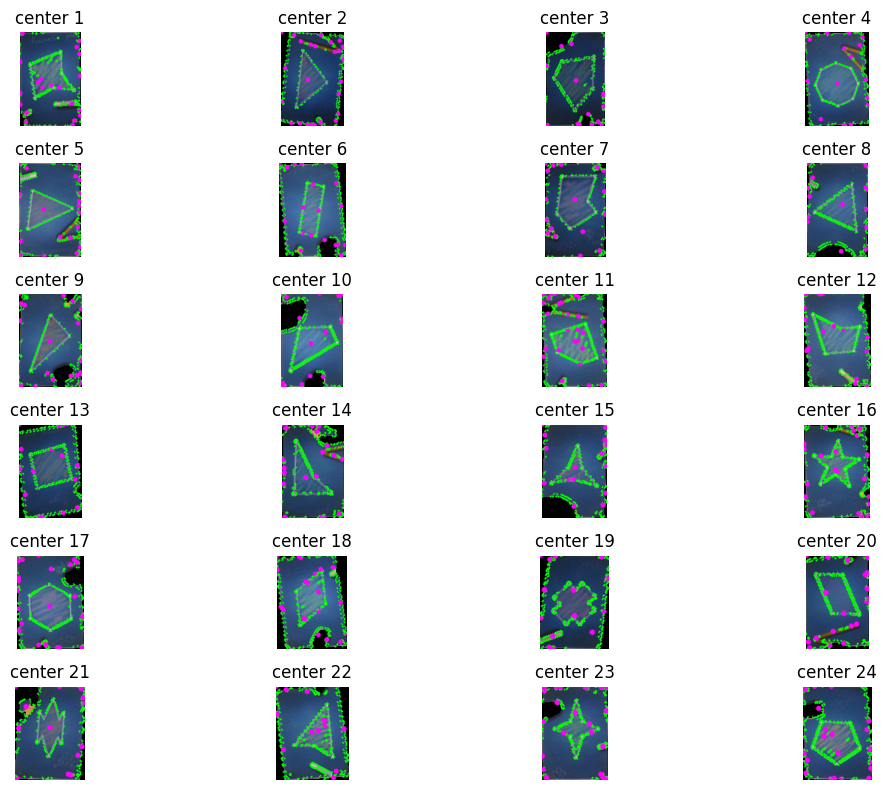

In [217]:
show_all_centers(rois)

In [218]:
def calculate_curvature(contour, step=1):
    curvature = []
    contour = contour[:, 0, :]  # reshape from (N, 1, 2) to (N, 2)
    n = len(contour)

    for i in range(n):
        prev = contour[(i - step) % n]
        curr = contour[i]
        next_ = contour[(i + step) % n]

        v1 = curr - prev
        v2 = next_ - curr

        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)

        if norm_v1 == 0 or norm_v2 == 0:
            continue

        cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))

        curvature.append(angle)

    curvature = np.array(curvature)
    return curvature

In [219]:
def adaptive_hist_knee_threshold(
    img,
    aggressive_pass=False,
    plot=False,
    min_threshold=0.005,
    second_pass=False,
    return_knee=False
):
    def find_knee(channel, threshold, exclude_zeros=False):
        """
        Улучшенная функция поиска knee с опцией исключения нулей
        """
        if exclude_zeros:
            # Исключаем нули из анализа для второго прохода
            non_zero_mask = channel > 0
            if np.sum(non_zero_mask) < 10:  # Слишком мало данных
                return None, None, None, None, None
            non_zero_values = channel[non_zero_mask]
            hist, bins = np.histogram(non_zero_values, bins=256, range=(1, 256))
            hist = np.concatenate([[0], hist])  # Добавляем нулевой бин
        else:
            hist = cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()
        
        cdf = hist.cumsum()
        if cdf[-1] == 0:
            return None, None, None, None, None
            
        cdf_norm = cdf / cdf[-1]
        grad = np.gradient(cdf_norm)
        second_grad = np.gradient(grad)
        
        # Улучшенный поиск knee
        # Ищем точку максимального изменения второй производной
        valid_range = range(5, len(second_grad) - 5)  # Избегаем краев
        
        for i in valid_range:
            if second_grad[i] > threshold and grad[i] > threshold:
                return i, hist, cdf_norm, grad, second_grad
        
        # Fallback: ищем максимум градиента в разумном диапазоне
        grad_in_range = grad[5:-5]
        if len(grad_in_range) > 0:
            knee_idx = np.argmax(grad_in_range) + 5
            return knee_idx, hist, cdf_norm, grad, second_grad
        
        return int(np.argmax(grad)), hist, cdf_norm, grad, second_grad
    
    # Первый проход
    t1 = min_threshold
    result = find_knee(img, t1)
    if result[0] is None:
        print("Не удалось найти knee в первом проходе")
        return img if not return_knee else (img, (None, None))
    
    knee1, hist1, cdf1, grad1, sec1 = result
    
    # Создаем маску для первого прохода
    first_pass_mask = img >= knee1
    masked = np.where(first_pass_mask, img, 0).astype(img.dtype)
    
    knee2 = None
    hist2 = cdf2 = grad2 = sec2 = None
    
    if second_pass:
        # Второй проход: работаем только с пикселями, прошедшими первый фильтр
        filtered_region = img[first_pass_mask]
        
        if len(filtered_region) > 50:  # Достаточно данных для анализа
            # Увеличиваем порог для более агрессивной фильтрации
            t2 = t1 * (3 if aggressive_pass else 1.5)
            
            result2 = find_knee(filtered_region, t2)
            if result2[0] is not None:
                knee2, hist2, cdf2, grad2, sec2 = result2
                
                # Применяем второй порог только к уже отфильтрованным пикселям
                final_mask = (img >= knee1) & (img >= knee2)
                masked = np.where(final_mask, 255, 0).astype(np.uint8)
            else:
                print("Не удалось найти knee во втором проходе")
        else:
            print("Недостаточно данных для второго прохода")
    
    # Визуализация
    if plot:
        plt.figure(figsize=(16, 8))
        
        # Оригинальное изображение
        plt.subplot(2, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # Результат
        plt.subplot(2, 4, 2)
        plt.imshow(masked, cmap='gray')
        plt.title('Filtered Result')
        plt.axis('off')
        
        # Гистограммы
        plt.subplot(2, 4, 3)
        plt.plot(hist1, label='Histogram 1', alpha=0.7)
        if hist2 is not None:
            plt.plot(hist2, label='Histogram 2', alpha=0.7)
        plt.axvline(knee1, color='red', linestyle='--', label=f'knee1 = {knee1}')
        if knee2 is not None:
            plt.axvline(knee2, color='orange', linestyle='--', label=f'knee2 = {knee2}')
        plt.legend()
        plt.title('Histograms')
        
        # CDF
        plt.subplot(2, 4, 4)
        plt.plot(cdf1, label='CDF 1', alpha=0.7)
        if cdf2 is not None:
            plt.plot(cdf2, label='CDF 2', alpha=0.7)
        plt.axvline(knee1, color='red', linestyle='--')
        if knee2 is not None:
            plt.axvline(knee2, color='orange', linestyle='--')
        plt.legend()
        plt.title('Cumulative Distribution')
        
        # Градиенты
        plt.subplot(2, 4, 5)
        plt.plot(grad1, label='Gradient 1', alpha=0.7)
        if grad2 is not None:
            plt.plot(grad2, label='Gradient 2', alpha=0.7)
        plt.axvline(knee1, color='red', linestyle='--')
        if knee2 is not None:
            plt.axvline(knee2, color='orange', linestyle='--')
        plt.legend()
        plt.title('Gradients')
        
        # Вторые производные
        plt.subplot(2, 4, 6)
        plt.plot(sec1, label='2nd deriv 1', alpha=0.7)
        if sec2 is not None:
            plt.plot(sec2, label='2nd deriv 2', alpha=0.7)
        plt.axvline(knee1, color='red', linestyle='--')
        if knee2 is not None:
            plt.axvline(knee2, color='orange', linestyle='--')
        plt.legend()
        plt.title('Second Derivatives')
        
        # Статистика
        plt.subplot(2, 4, 7)
        plt.text(0.1, 0.8, f'knee1: {knee1}', transform=plt.gca().transAxes)
        plt.text(0.1, 0.6, f'knee2: {knee2}', transform=plt.gca().transAxes)
        plt.text(0.1, 0.4, f'Pixels > knee1: {np.sum(img >= knee1)}', transform=plt.gca().transAxes)
        if knee2 is not None:
            plt.text(0.1, 0.2, f'Final pixels: {np.sum(masked > 0)}', transform=plt.gca().transAxes)
        plt.axis('off')
        plt.title('Statistics')
        
        plt.tight_layout()
        plt.show()
    
    if return_knee:
        return masked, (knee1, knee2)
    return masked

In [220]:
def adaptive_hist_knee_threshold_balanced(
    img,
    aggressive_pass=False,
    plot=False,
    min_threshold=0.005,
    second_pass=False,
    return_knee=False,
    rebalance_method='stretch'  # 'stretch', 'histogram_eq', 'clahe'
):
    """
    Функция с балансировкой гистограммы между проходами
    
    rebalance_method:
    - 'stretch': простое растяжение контраста (min->0, max->255)
    - 'histogram_eq': глобальная эквализация гистограммы
    - 'clahe': адаптивная эквализация (CLAHE)
    """
    
    def find_knee(channel, threshold, title=""):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()
        cdf = hist.cumsum()
        if cdf[-1] == 0:
            return None, hist, None, None, None
            
        cdf_norm = cdf / cdf[-1]
        grad = np.gradient(cdf_norm)
        second_grad = np.gradient(grad)
        
        # Улучшенный поиск knee
        valid_indices = []
        for i in range(5, len(second_grad) - 5):
            if second_grad[i] > threshold and grad[i] > threshold:
                valid_indices.append(i)
        
        if valid_indices:
            knee_idx = valid_indices[0]  # Берем первый найденный
        else:
            # Fallback: максимум градиента
            knee_idx = int(np.argmax(grad[5:-5])) + 5
        
        if plot and title:
            print(f"{title}: knee = {knee_idx}, pixels > knee = {np.sum(channel >= knee_idx)}")
        
        return knee_idx, hist, cdf_norm, grad, second_grad
    
    def rebalance_image(img, method='stretch'):
        """Балансировка изображения для восстановления контраста"""
        if method == 'stretch':
            # Простое растяжение контраста
            min_val = np.min(img[img > 0])  # Исключаем нули
            max_val = np.max(img)
            if max_val > min_val:
                stretched = ((img.astype(np.float32) - min_val) / (max_val - min_val) * 255)
                stretched = np.clip(stretched, 0, 255).astype(np.uint8)
                # Сохраняем нули как нули
                stretched = np.where(img == 0, 0, stretched)
                return stretched
            return img
            
        elif method == 'histogram_eq':
            # Глобальная эквализация гистограммы
            non_zero_mask = img > 0
            if np.sum(non_zero_mask) == 0:
                return img
            
            # Создаем временное изображение для эквализации
            temp_img = img.copy().astype(np.uint8)
            # Заменяем нули на минимальное ненулевое значение для эквализации
            min_non_zero = np.min(img[non_zero_mask])
            temp_img[~non_zero_mask] = min_non_zero
            
            # Применяем эквализацию ко всему изображению
            equalized = cv2.equalizeHist(temp_img)
            
            # Возвращаем нули обратно
            equalized = equalized.astype(np.uint8)
            equalized[~non_zero_mask] = 0
            return equalized
            
        elif method == 'clahe':
            # Адаптивная эквализация
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            if len(img.shape) == 2:
                equalized = clahe.apply(img.astype(np.uint8))
            else:
                # Для цветных изображений (если нужно)
                equalized = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                equalized[:,:,0] = clahe.apply(equalized[:,:,0])
                equalized = cv2.cvtColor(equalized, cv2.COLOR_LAB2BGR)
            return equalized
        
        return img
    
    # Первый проход
    original_img = img.copy()
    t1 = min_threshold
    
    result1 = find_knee(img, t1, "Первый проход")
    if result1[0] is None:
        print("Не удалось найти knee в первом проходе")
        return img if not return_knee else (img, (None, None))
    
    knee1, hist1, cdf1, grad1, sec1 = result1
    
    # Создаем маску после первого прохода
    first_mask = img >= knee1
    after_first_pass = np.where(first_mask, img, 0)
    
    knee2 = None
    hist2 = cdf2 = grad2 = sec2 = None
    rebalanced_img = None
    
    if second_pass:
        print(f"\nПосле первого прохода: min={np.min(after_first_pass[first_mask])}, max={np.max(after_first_pass)}")
        
        # КЛЮЧЕВОЙ МОМЕНТ: Балансируем изображение перед вторым проходом
        rebalanced_img = rebalance_image(after_first_pass, method=rebalance_method)
        
        print(f"После балансировки ({rebalance_method}): min={np.min(rebalanced_img[rebalanced_img > 0])}, max={np.max(rebalanced_img)}")
        
        # Второй проход на сбалансированном изображении
        t2 = t1 * (2 if aggressive_pass else 1.5)
        result2 = find_knee(rebalanced_img, t2, "Второй проход (после балансировки)")
        
        if result2[0] is not None:
            knee2, hist2, cdf2, grad2, sec2 = result2
            
            # Финальная маска применяется к сбалансированному изображению
            final_mask = rebalanced_img >= knee2
            masked = np.where(final_mask, 255, 0).astype(np.uint8)
        else:
            print("Не удалось найти knee во втором проходе")
            masked = np.where(after_first_pass > 0, 255, 0).astype(np.uint8)
    else:
        masked = np.where(after_first_pass > 0, 255, 0).astype(np.uint8)
    
    # Расширенная визуализация
    if plot:
        fig_height = 12 if second_pass else 8
        plt.figure(figsize=(20, fig_height))
        
        row1_plots = 5 if second_pass else 4
        row2_plots = 4 if second_pass else 3
        
        # Ряд 1: Изображения
        plt.subplot(3, row1_plots, 1)
        plt.imshow(original_img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(3, row1_plots, 2)
        plt.imshow(after_first_pass, cmap='gray')
        plt.title(f'After 1st pass\n(knee1={knee1})')
        plt.axis('off')
        
        if second_pass and rebalanced_img is not None:
            plt.subplot(3, row1_plots, 3)
            plt.imshow(rebalanced_img, cmap='gray')
            plt.title(f'Rebalanced\n({rebalance_method})')
            plt.axis('off')
            
            plt.subplot(3, row1_plots, 4)
            plt.imshow(masked, cmap='gray')
            plt.title(f'Final result\n(knee2={knee2})')
            plt.axis('off')
            
            # График распределений
            plt.subplot(3, row1_plots, 5)
            plt.hist(original_img.flatten(), bins=50, alpha=0.5, label='Original', density=True)
            plt.hist(after_first_pass[after_first_pass > 0].flatten(), bins=50, alpha=0.5, label='After 1st', density=True)
            plt.hist(rebalanced_img[rebalanced_img > 0].flatten(), bins=50, alpha=0.5, label='Rebalanced', density=True)
            plt.legend()
            plt.title('Pixel distributions')
        else:
            plt.subplot(3, row1_plots, 3)
            plt.imshow(masked, cmap='gray')
            plt.title('Final result')
            plt.axis('off')
        
        # Ряд 2: Гистограммы и CDF
        plt.subplot(3, row2_plots, 1)
        plt.plot(hist1, label='Hist 1', alpha=0.7)
        if hist2 is not None:
            plt.plot(hist2, label=f'Hist 2 (rebalanced)', alpha=0.7)
        plt.axvline(knee1, color='red', linestyle='--', label=f'knee1={knee1}')
        if knee2 is not None:
            plt.axvline(knee2, color='orange', linestyle='--', label=f'knee2={knee2}')
        plt.legend()
        plt.title('Histograms')
        plt.yscale('log')  # Логарифмическая шкала для лучшей видимости
        
        plt.subplot(3, row2_plots, 2)
        plt.plot(cdf1, label='CDF 1', alpha=0.7)
        if cdf2 is not None:
            plt.plot(cdf2, label='CDF 2 (rebalanced)', alpha=0.7)
        plt.axvline(knee1, color='red', linestyle='--')
        if knee2 is not None:
            plt.axvline(knee2, color='orange', linestyle='--')
        plt.legend()
        plt.title('Cumulative Distribution')
        
        plt.subplot(3, row2_plots, 3)
        plt.plot(grad1, label='Grad 1', alpha=0.7)
        if grad2 is not None:
            plt.plot(grad2, label='Grad 2 (rebalanced)', alpha=0.7)
        plt.axvline(knee1, color='red', linestyle='--')
        if knee2 is not None:
            plt.axvline(knee2, color='orange', linestyle='--')
        plt.legend()
        plt.title('Gradients')
        
        if second_pass:
            plt.subplot(3, row2_plots, 4)
            plt.plot(sec1, label='2nd deriv 1', alpha=0.7)
            if sec2 is not None:
                plt.plot(sec2, label='2nd deriv 2 (rebalanced)', alpha=0.7)
            plt.axvline(knee1, color='red', linestyle='--')
            if knee2 is not None:
                plt.axvline(knee2, color='orange', linestyle='--')
            plt.legend()
            plt.title('Second Derivatives')
        
        # Ряд 3: Статистика
        stats_text = f"""
        Original: min={np.min(original_img)}, max={np.max(original_img)}, mean={np.mean(original_img):.1f}
        After 1st pass: pixels={np.sum(first_mask)}, min={np.min(after_first_pass[first_mask])}, max={np.max(after_first_pass)}
        """
        
        if second_pass and rebalanced_img is not None:
            non_zero_rebalanced = rebalanced_img[rebalanced_img > 0]
            stats_text += f"""
        Rebalanced: min={np.min(non_zero_rebalanced)}, max={np.max(non_zero_rebalanced)}, mean={np.mean(non_zero_rebalanced):.1f}
        Final: pixels={np.sum(masked > 0)}
        Thresholds: knee1={knee1}, knee2={knee2}
        """
        
        plt.subplot(3, 1, 3)
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
                verticalalignment='top', fontfamily='monospace', fontsize=10)
        plt.axis('off')
        
        # plt.tight_layout()
        plt.show()
    
    if return_knee:
        return masked, (knee1, knee2)
    return masked

In [221]:
def rebalance_image(img, method='stretch'):
    if method == 'stretch':
        non_zero = img[img > 0]
        if non_zero.size == 0:
            return img
        min_val = np.min(non_zero)
        max_val = np.max(img)
        if max_val > min_val:
            stretched = (img.astype(np.float32) - min_val) / (max_val - min_val) * 255
            stretched = np.clip(stretched, 0, 255).astype(np.uint8)
            stretched = np.where(img == 0, 0, stretched)
            return stretched
        return img

    elif method == 'histogram_eq':
        mask = img > 0
        if np.sum(mask) == 0:
            return img
        temp = img.copy()
        min_non_zero = np.min(temp[mask])
        temp[~mask] = min_non_zero
        eq = cv2.equalizeHist(temp.astype(np.uint8))
        eq[~mask] = 0
        return eq

    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img.astype(np.uint8))

    elif method == 'power':
        # Усиление яркого — подавление слабого (power-law)
        img_float = img.astype(np.float32) / 255.0
        boosted = np.power(img_float, 2.2)  # γ = 2.2, можно настраивать
        boosted = np.clip(boosted * 255, 0, 255).astype(np.uint8)
        return boosted

    return img

In [222]:
def adaptive_hist_knee_threshold_multi(
    img,
    passes=2,
    min_threshold=0.005,
    aggressive_pass=True,
    rebalance_method='stretch',  # 'stretch', 'histogram_eq', 'clahe'
    plot=False,
    return_knees=False
):
    """
    Многоцикловый адаптивный knee-based порог с перебалансировкой яркости.
    """
    def find_knee(channel, threshold):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()
        cdf = hist.cumsum()
        if cdf[-1] == 0:
            return None, hist, None, None, None
        cdf_norm = cdf / cdf[-1]
        grad = np.gradient(cdf_norm)
        second_grad = np.gradient(grad)
        for i in range(5, len(second_grad) - 5):
            if second_grad[i] > threshold and grad[i] > threshold:
                return i, hist, cdf_norm, grad, second_grad
        return int(np.argmax(grad[5:-5])) + 5, hist, cdf_norm, grad, second_grad

    original = img.copy()
    current = img.copy()
    knees = []
    images = [original]
    hists, cdfs, grads, s_grads = [], [], [], []

    for i in range(passes):
        t = min_threshold * (2 if aggressive_pass else 1.5) ** i
        knee, hist, cdf, grad, s_grad = find_knee(current, t)
        if knee is None:
            print(f"[{i+1}] Пропуск: не найден knee.")
            break
        knees.append(knee)
        hists.append(hist)
        cdfs.append(cdf)
        grads.append(grad)
        s_grads.append(s_grad)
        mask = current >= knee
        current = np.where(mask, current, 0).astype(np.uint8)
        current = rebalance_image(current, rebalance_method)
        current = cv2.GaussianBlur(current, (5, 5), 0)
        # current = np.where(current >= knee, current, 0).astype(np.uint8)
        images.append(current)

    # итоговая бинаризация
    final = np.where(current > 0, 255, 0).astype(np.uint8)

    if plot:
        fig, axs = plt.subplots(nrows=3, ncols=passes, figsize=(5 * passes, 10))
        for i in range(passes):
            # изображения
            axs[0, i].imshow(255-images[i + 1], cmap='gray')
            axs[0, i].set_title(f'Pass {i+1}\nknee={knees[i]}')
            axs[0, i].axis('off')
            # гистограммы
            axs[1, i].plot(hists[i])
            axs[1, i].axvline(knees[i], color='red', linestyle='--')
            axs[1, i].set_title(f'Histogram {i+1}')
            axs[1, i].set_yscale('log')
            # производные
            axs[2, i].plot(grads[i], label='1st deriv')
            axs[2, i].plot(s_grads[i], label='2nd deriv')
            axs[2, i].axvline(knees[i], color='red', linestyle='--')
            axs[2, i].legend()
            axs[2, i].set_title(f'Derivatives {i+1}')
        plt.tight_layout()
        plt.show()

    if return_knees:
        return final, knees
    return final

UP AND UP!


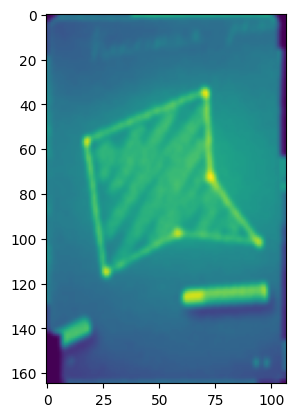

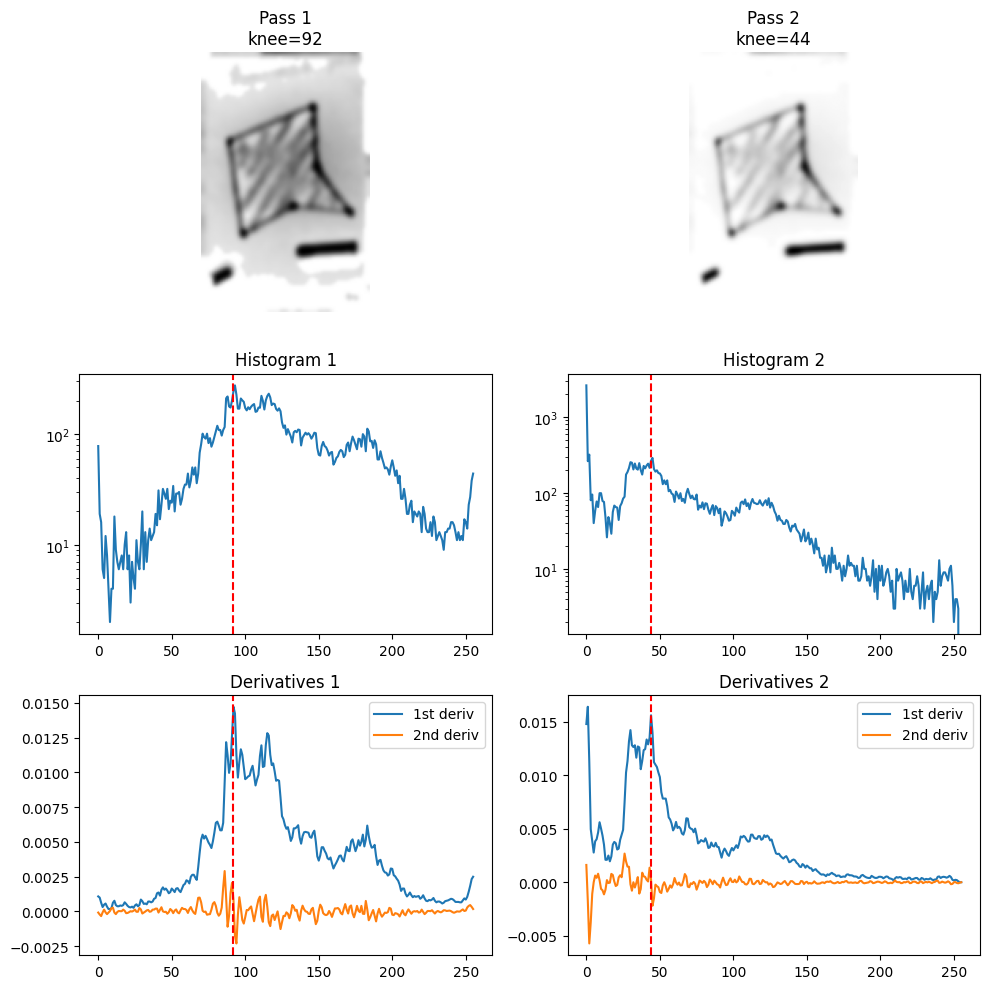

DEBUG bad area, just too small
1, 217.0
DEBUG bad area, just too small
3, 356.5
CONTIK FITERRED 1
BRIH [ 2.55000000e+02 -1.10844667e-12]
DFDFDFF  1
bad area, just too much
1, 11681.5
LEN =  1
11681.5 849.1442233324051 0.20358489783353856 9
Curvature STD: 0.6165603031870692
poly


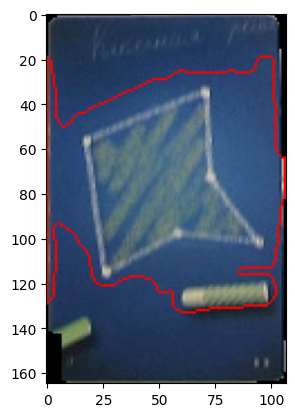

In [280]:
roi = rois[0]
see(roi)
roi = auto_white_balance(roi)

gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

#####
# gray = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5, 5))
# enhanced = clahe.apply(gray)
see(gray)

#####

##### get rid of hatching
# blur1 = cv2.GaussianBlur(enhanced, (3, 3), 0)
# blur2 = cv2.GaussianBlur(enhanced, (13, 13), 0)
# 
# dog = cv2.subtract(blur1, blur2)
# dog = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)
# dog = dog.astype(np.uint8)
# see(dog)
#####


##### top-hat
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
enhanced = cv2.add(gray, tophat)
enhanced = cv2.subtract(enhanced, blackhat)
#####
enhanced = cv2.GaussianBlur(enhanced, (5, 5), 0)

####
mean, stddev = cv2.meanStdDev(enhanced)
brightness = mean[0][0]
contrast = stddev[0][0]

if brightness < 100 and contrast < 50:
    print("UP AND UP!")
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
####

closed_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
enhanced = cv2.morphologyEx(enhanced, cv2.MORPH_CLOSE, closed_kernel, iterations=1)

# see(enhanced)

enhanced = cv2.GaussianBlur(enhanced, (5, 5), 0)

# hist = cv2.calcHist([enhanced], [0], None, [256], [0, 256]).flatten()
# cdf = hist.cumsum()
# cdf_normalized = cdf / cdf[-1]
# 
# # 2. Первая производная (градиент)
# grad = np.gradient(cdf_normalized)
# 
# # 3. Вторая производная — чтобы найти ускорение роста (перегиб)
# second_grad = np.gradient(grad)
# 
# # 4. Найдём первую точку, где вторая производная резко возрастает
# # Это означает: начинаем быстро подниматься
# # Условия: градиент уже начинает расти, и вторая производная > порога
# threshold = 0.005
# for i in range(1, len(second_grad)):
#     if second_grad[i] > threshold and grad[i] > threshold:
#         knee = i
#         break
# else:
#     knee = int(np.argmax(grad))  # fallback
# 
# # 5. Применим порог
# _, mask = cv2.threshold(enhanced, knee, 255, cv2.THRESH_BINARY)
# 
# # 6. Визуализация
# plt.figure(figsize=(14, 4))
# 
# plt.subplot(1, 3, 1)
# plt.plot(hist, label='Histogram')
# plt.axvline(knee, color='red', linestyle='--', label=f'Threshold = {knee}')
# plt.legend()
# 
# plt.subplot(1, 3, 2)
# plt.plot(cdf_normalized, label='CDF')
# plt.axvline(knee, color='red', linestyle='--')
# plt.legend()
# 
# plt.subplot(1, 3, 3)
# plt.plot(grad, label='Gradient (1st deriv)')
# plt.plot(second_grad, label='2nd deriv (acceleration)')
# plt.axvline(knee, color='red', linestyle='--')
# plt.legend()
# 
# plt.tight_layout()
# plt.show()

# binary_mask = (enhanced >= 92).astype(np.uint8) * 255
# masked = np.where(enhanced >= knee, enhanced, 0).astype(np.uint8)
# see(masked)

# masked = adaptive_hist_knee_threshold(enhanced, second_pass=True, aggressive_pass=True, plot=True)

# masked_hist_eq = adaptive_hist_knee_threshold_balanced(
#     enhanced, 
#     second_pass=True, 
#     aggressive_pass=True,
#     plot=True,
#     rebalance_method='smooth'
# )

masked = adaptive_hist_knee_threshold_multi(
    enhanced,
    passes=2,
    aggressive_pass=True,
    plot=True,
    rebalance_method='power'
)

# enhanced = masked_hist_eq

enhanced = masked

# closed_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# enhanced = cv2.morphologyEx(enhanced, cv2.MORPH_CLOSE, closed_kernel, iterations=1)

see(enhanced)

# mmm = cv2.Canny(enhanced, 50, 150)

# see(mmm)

contik, _ = cv2.findContours(enhanced, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
i_brit = roi.copy()
show_contours(i_brit, contik, thickness=1)
see(i_brit)

i_kmeans = roi.copy()

areas = np.array([cv2.contourArea(cnt) for cnt in contik])

log_areas = np.log1p(areas).reshape(-1, 1)  # log(1 + area)
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0).fit(log_areas)
labels = kmeans.labels_

big_cluster = np.argmax([areas[labels == i].mean() for i in range(2)])
contours_big = [cnt for i, cnt in enumerate(contik) if labels[i] == big_cluster]

# show_contours(i_kmeans, contours_big, thickness=1)
# see(i_kmeans)

contik_filtered = []
for i, cnt in enumerate(contours_big, 1):
    area = cv2.contourArea(cnt)
    if area > 800:
        contik_filtered.append(cnt)
    else:
        print("DEBUG bad area, just too small")
        print(f"{i}, {area}")

print("CONTIK FITERRED", len(contik_filtered))
contours_big = contik_filtered

show_contours(i_kmeans, contours_big, thickness=1)
see(i_kmeans)

# hist = cv2.calcHist([enhanced], [0], None, [256], [0, 256]).flatten()
# cdf = hist.cumsum()
# cdf_normalized = cdf / cdf[-1]
# 
# bg_threshold = np.searchsorted(cdf_normalized, 0.50)
# 
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.plot(hist, label='Histogram')
# plt.axvline(bg_threshold, color='r', linestyle='--', label=f'Threshold = {bg_threshold}')
# plt.legend()
# 
# plt.subplot(1, 2, 2)
# plt.plot(cdf_normalized, label='CDF')
# plt.axvline(bg_threshold, color='r', linestyle='--')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(hist)
# plt.show()

## KMEANS
pixels = enhanced.flatten().reshape(-1, 1)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pixels)

centers = kmeans.cluster_centers_.flatten()
brightest_label = centers.argmax()
print("BRIH", centers)
brightest_mask = (kmeans.labels_ == brightest_label).astype(np.uint8).reshape(enhanced.shape) * 255
enhanced = brightest_mask
#see(enhanced)
##########

## DBSCAN
# h, w = enhanced.shape
# X = []
# 
# for y in range(h):
#     for x in range(w):
#         brightness = enhanced[y, x]
#         X.append([x, y, brightness])
# 
# X = np.array(X)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# db = DBSCAN(eps=0.6, min_samples=10).fit(X_scaled)
# labels = db.labels_
# 
# unique_labels = np.unique(labels)
# print("UNIQ:", unique_labels)
# colors = cm.get_cmap('tab20', len(unique_labels))
# cluster_viz = np.zeros((h, w, 3), dtype=np.uint8)
# 
# for i, label in enumerate(unique_labels):
#     if label == -1:
#         continue
# 
#     color = np.array(colors(i)[:3]) * 255  # RGB из colormap
#     mask = (labels == label).reshape(h, w)
#     cluster_viz[mask] = color.astype(np.uint8)
# 
# plt.figure(figsize=(10, 10))
# plt.title("DBSCAN Кластеры")
# plt.imshow(cluster_viz)
# plt.axis('off')
# plt.show()
#########
mm = cv2.GaussianBlur(brightest_mask, (5, 5), 0)
open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opened = cv2.morphologyEx(mm, cv2.MORPH_OPEN, open_kernel, iterations=1)

close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, close_kernel, iterations=3)

brightest_mask = closed

# see(brightest_mask)

contik, _ = cv2.findContours(brightest_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
i_brit = roi.copy()
show_contours(i_brit, contik, thickness=1)
# see(i_brit)

print("DFDFDFF ", len(contik))
# watershed_mask = np.uint8(markers == -1) * 255
# see(watershed_mask)

# 
# 
# see(mm)
# 

# _, mask = cv2.threshold(enhanced, threshold_val, 255, cv2.THRESH_BINARY)


# enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
# see(enhanced)

# see(enhanced)

enhanced = cv2.GaussianBlur(mm, (5, 5), 0)
open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opened = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, open_kernel, iterations=1)

close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, close_kernel, iterations=1)

enhanced = closed
# see(enhanced)

i_c = roi.copy()

#####
# _, bin_mask = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# bin_mask = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  cv2.THRESH_BINARY, 15, 5)

# see(bin_mask)

# kernel = np.ones((3, 3), np.uint8)
# opening = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, kernel, iterations=1)
# see(opening)
# 
# dist_transform = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
# _, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)

# sure_fg = np.uint8(sure_fg)

# Находим контуры по градиенту
######

# nn = cv2.Canny(enhanced, 50, 150)
# see(nn)

# contik, _ = cv2.findContours(enhanced, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# i_cont = roi.copy()
# show_contours(i_cont, contik)
# see(i_cont)

contik_filtered = []
for i, cnt in enumerate(contik, 1):
    area = cv2.contourArea(cnt)
    if area < 100:
        contik_filtered.append(cnt)
    else:
        print("bad area, just too much")
        print(f"{i}, {area}")


contours = contik
#####
# nn = cv2.Canny(enhanced, 50, 150)
# see(nn)
# contours = get_contours_by_mask_new(nn)
# # show_contours(i_c, contours)
# cv2.drawContours(i_c, contours, -1, 255, thickness=1)
# see(i_c)

i_test = roi.copy()
c_t = contours[0]
show_contours(i_test, c_t)
# see(i_test)

print("LEN = ", len(contours))

#####
cct = c_t
pts = cct[:, 0, :]
x = pts[:, 0]
y = pts[:, 1]

#####

M = cv2.moments(c_t)
if M["m00"] == 0:
    cx, cy = 0, 0
else:
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

points = c_t[:, 0, :]
center = np.array([cx, cy])
dists = np.linalg.norm(points - center, axis=1)

i_viz = roi.copy()
for (x, y), d in zip(points, dists):
    cv2.circle(i_viz, (x, y), 1, (0, 255, 0), -1)

cv2.circle(i_viz, (cx, cy), 4, (0, 0, 255), -1) # center
# see(i_viz)

######
area = cv2.contourArea(c_t) 
perimeter = cv2.arcLength(c_t, True)
compactness = (4 * np.pi * area) / (perimeter ** 2)
approx = cv2.approxPolyDP(c_t, 0.02 * perimeter, True)
vertex_count = len(approx)
print(area, perimeter, compactness, vertex_count)

curvatures = calculate_curvature(c_t, step=2)
std_curvature = np.std(curvatures)
mean_curvature = np.mean(curvatures)

print("Curvature STD:", std_curvature)

if std_curvature > 0.18:
    print("poly")
else:
    print("smooth")
######

# print(f"perim {perim}, comp {compactness}")
# approx = cv2.approxPolyDP(c_t, 0.01 * perim, True)
# num_vertices = len(approx)
# print(num_vertices)

# is_convex = cv2.isContourConvex(c_t)
# print(is_convex)
# hull = cv2.convexHull(c_t)
# show_contours(i_test, hull)
# cv2.drawContours(i_test, [hull], -1, (0, 255, 0), 2)
# see(i_test)

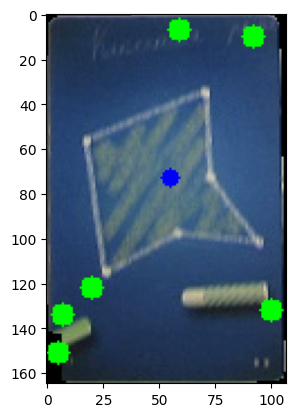

In [224]:
# find peaks
min_dist_between_peaks = 5
peaks, _ = find_peaks(dists, distance=min_dist_between_peaks, prominence=5)
i_peaks = roi.copy()

for idx in peaks:
    x, y = points[idx]
    cv2.circle(i_peaks, (x, y), 5, (0, 255, 0), -1)

cv2.circle(i_peaks, (cx, cy), 4, (0, 0, 255), -1)
see(i_peaks)

In [225]:
lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
h, w, _ = lab.shape
lab_flat = lab.reshape((-1, 3))

kmeans = KMeans(n_clusters=10, n_init=15, random_state=42)
labels = kmeans.fit_predict(lab_flat)
labels_img = labels.reshape((h, w))


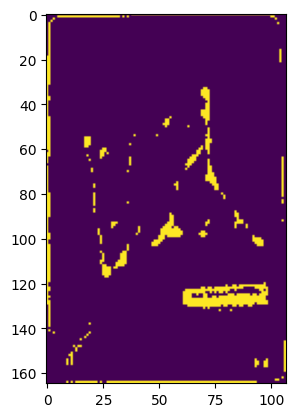

In [226]:
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

lower_white = np.array([0, 0, 10])
upper_white = np.array([180, 50, 255])

chalk_mask = cv2.inRange(hsv_roi, lower_white, upper_white)
see(chalk_mask)

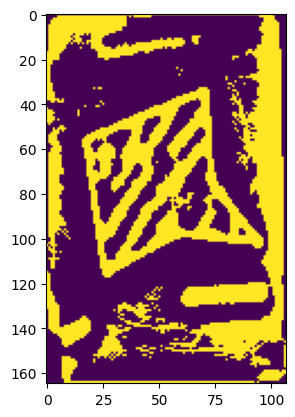

In [227]:
gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
gray_roi = cv2.medianBlur(gray_roi, 5)
# _, bin_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Адаптивный порог: локальный контраст, работает даже при плохом освещении
bin_roi = cv2.adaptiveThreshold(
    gray_roi, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV,  # инверсия сразу
    blockSize=31,  # локальный размер окна (нечётное число)
    C=0
)

bin_roi = 255 - bin_roi
see(gray_roi)
see(bin_roi)

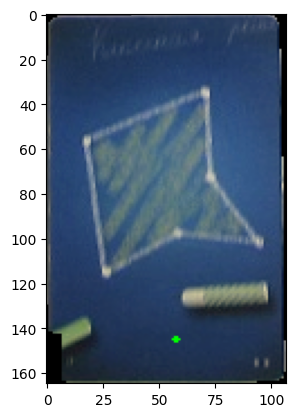

In [228]:
inner_contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
roi_copy = roi.copy()
cv2.drawContours(roi_copy, inner_contours[10], -1, (0, 255, 0), 2)
see(roi_copy)

In [229]:
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=10,  minLineLength=10, maxLineGap=10)

In [230]:
line_image = img.copy()
draw_lines(line_image, lines.reshape(-1, 4), [255, 0, 0])

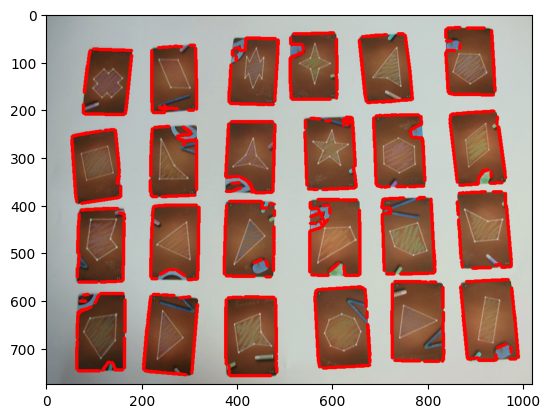

In [231]:
see(line_image)

In [232]:
ll_img = np.zeros_like(base_mask)
draw_lines(ll_img, lines.reshape(-1, 4), [255, 0, 0], thickness=1)
new_edges = cv2.Canny(ll_img, 50, 150)

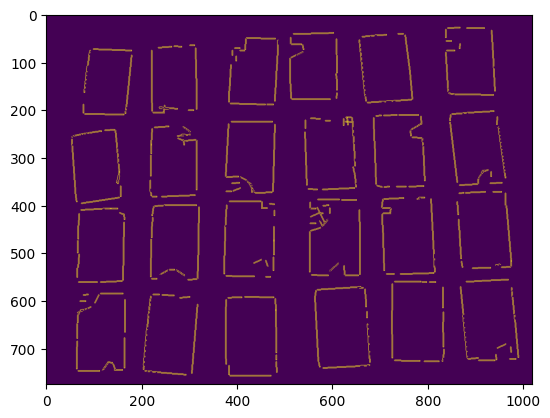

In [233]:
see(new_edges)

In [234]:
new_lines = cv2.HoughLinesP(new_edges, rho=1, theta=np.pi/180, threshold=10,  minLineLength=10, maxLineGap=10)

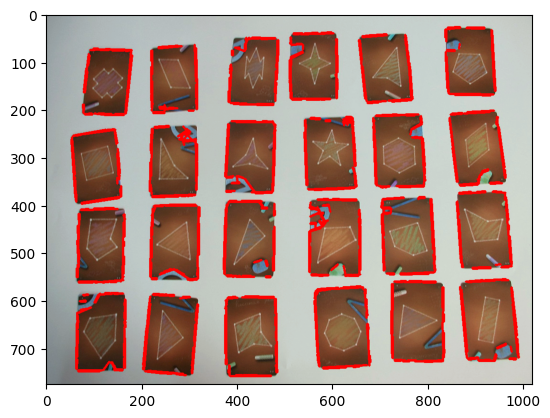

In [235]:
new_img = img.copy()
draw_lines(new_img, new_lines.reshape(-1, 4), [255, 0, 0], thickness=3)
see(new_img)
lines = new_lines

# Разобьем на отрезки на кластеры

Нам нужно получить группы паралелльных линий для всего изображения

Когда мы это сделаем, мы сможем их как-нибудь обрабатывать.

In [236]:
ANGLE_TOLERANCE = 5
RHO_TOLERANCE = 10

In [237]:
if lines is None:
    print("Линий не найдено")
else:
    clusters = cluster_lines_by_angle(lines, ANGLE_TOLERANCE)

    clustered_img = img.copy()
    colors = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(len(clusters))]

    for idx, cluster in enumerate(clusters):
        draw_lines(clustered_img, np.array(cluster['lines']), colors[idx])

    print(f"Найдено кластеров: {len(clusters)}")

Найдено кластеров: 22


In [238]:
def merge_cluster_to_line(cluster):
    lines = cluster['lines']
    angle_deg = cluster['angle']
    angle_rad = np.radians(angle_deg)
    
    dx = np.cos(angle_rad)
    dy = np.sin(angle_rad)
    direction = np.array([dx, dy])
    
    points = []
    for x1, y1, x2, y2 in lines:
        points.append((x1, y1))
        points.append((x2, y2))
    
    projections = []
    for x, y in points:
        point = np.array([x, y])
        proj = np.dot(point, direction)
        projections.append((proj, (x, y)))

    projections.sort()
    start_point = projections[0][1]
    end_point = projections[-1][1]
    
    return (*start_point, *end_point)  # x1, y1, x2, y2

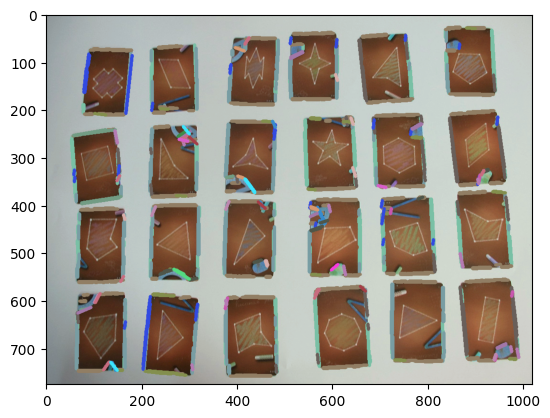

In [239]:
see(clustered_img)

In [240]:
merged_lines = []
for cluster in clusters:
    merged_line = merge_cluster_to_line(cluster)
    merged_lines.append(merged_line)

img_m = img.copy()
draw_lines(img_m, merged_lines, [255, 255, 0], 5)

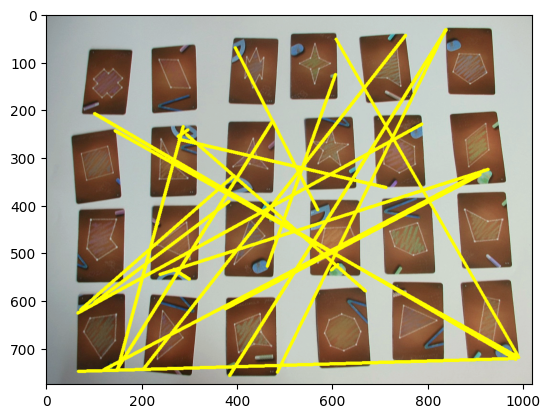

In [241]:
see(img_m)

In [242]:
print(f"[DEBUG] Всего кластеров: {len(clusters)}")
for i, cl in enumerate(clusters):
    print(f"  Кластер {i}: угол={cl['angle']:.2f}, кол-во линий={len(cl['lines'])}")

[DEBUG] Всего кластеров: 22
  Кластер 0: угол=87.90, кол-во линий=119
  Кластер 1: угол=-88.86, кол-во линий=135
  Кластер 2: угол=-1.65, кол-во линий=248
  Кластер 3: угол=83.44, кол-во линий=40
  Кластер 4: угол=-9.26, кол-во линий=7
  Кластер 5: угол=4.19, кол-во линий=29
  Кластер 6: угол=-82.95, кол-во линий=35
  Кластер 7: угол=-78.05, кол-во линий=5
  Кластер 8: угол=61.14, кол-во линий=10
  Кластер 9: угол=-17.59, кол-во линий=12
  Кластер 10: угол=42.52, кол-во линий=3
  Кластер 11: угол=78.24, кол-во линий=10
  Кластер 12: угол=-67.45, кол-во линий=4
  Кластер 13: угол=-59.38, кол-во линий=10
  Кластер 14: угол=30.18, кол-во линий=2
  Кластер 15: угол=-25.93, кол-во линий=10
  Кластер 16: угол=19.27, кол-во линий=4
  Кластер 17: угол=72.31, кол-во линий=6
  Кластер 18: угол=-40.60, кол-во линий=1
  Кластер 19: угол=12.56, кол-во линий=2
  Кластер 20: угол=-33.69, кол-во линий=1
  Кластер 21: угол=52.25, кол-во линий=4


# [exper] Попробуем (зачем-то) найти средний размер карточки (т.е. a и b)

## GYPSY TRY

In [243]:
pairs, dists = gypsy_pairs(clusters)

Cluster: 0
S_min: 66.66666666666667, S_max: 13949.167328121599
X: 48.21681471596397
l1_min, l2_min: 10.0, 10.0
l1_max, l2_max: 136.09188072769072, 153.20900756809309
[INSIDE] cluster_id_0: s = 5355.0, h = 315.0
[INSIDE] cluster_id_0: s = 4669.9420599392015, h = 321.8753729116874
[INSIDE] cluster_id_0: s = 5641.68033689856, h = 161.1349112970338
[INSIDE] cluster_id_0: s = 3234.0, h = 132.0
[INSIDE] cluster_id_0: s = 7069.486687721054, h = 170.18433760807653
[INSIDE] cluster_id_0: s = 11936.15285791337, h = 384.3462998903699
[INSIDE] cluster_id_0: s = 10878.168516745576, h = 211.15341864029338
[INSIDE] cluster_id_0: s = 5036.389734387495, h = 214.13919578452416
[INSIDE] cluster_id_0: s = 5658.0, h = 164.0
[INSIDE] cluster_id_0: s = 3119.3989223989806, h = 178.18170685523992
[INSIDE] cluster_id_0: s = 7277.139707542365, h = 484.87711728128085
[INSIDE] cluster_id_0: s = 2047.0, h = 178.0
[INSIDE] cluster_id_0: s = 5313.764334488205, h = 225.93271791627467
[INSIDE] cluster_id_0: s = 5054.0,

[ 172.  276.  429.  587. 1528.]
len(dists): 19391


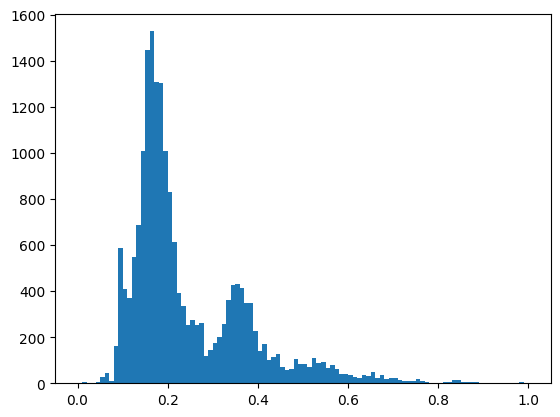

In [244]:
dists_norm = (dists - np.min(dists)) / (np.max(dists) - np.min(dists))
counts, bins, patches = plt.hist(dists_norm, bins=100)

bin_centers = (bins[:-1] + bins[1:]) / 2
min_peak_distance = 0.03
distance_in_bins = int(min_peak_distance * len(bin_centers))

peaks, _ = find_peaks(counts, distance=distance_in_bins)

top_two_peaks = np.sort(counts[peaks])[-5:]
print(top_two_peaks)
print(f"len(dists): {len(dists)}")

In [245]:
def visualize_dbscan_on_distances(distances, eps=30, min_samples=10):
    distances = np.array(distances).reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(distances)
    labels = clustering.labels_

    # Подготовим цвета
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(12, 6))
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(np.where(mask)[0], distances[mask], label=f'Кластер {label}', color=color, s=10)

    plt.title("DBSCAN кластеризация расстояний между линиями")
    plt.xlabel("Индекс пары")
    plt.ylabel("Расстояние между линиями")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return labels

In [246]:
def find_optimal_eps(dists, min_samples, target_ratio=2/3, tolerance=0.05):
    dists = np.asarray(dists).reshape(-1, 1)
    
    for eps in np.arange(1.0, 10.1, 0.5):
        labels = visualize_dbscan_on_distances(dists, eps=eps, min_samples=min_samples)
        unique_labels = np.unique(labels[labels != -1])
        
        if len(unique_labels) < 2:
            continue
            
        cluster_means = []
        for label in unique_labels:
            mask = (labels == label).flatten()
            cluster_data = dists[mask]
            if len(cluster_data) > 5:
                cluster_means.append(np.mean(cluster_data))
        
        cluster_means = sorted(cluster_means)
        for i in range(len(cluster_means)):
            for j in range(i+1, len(cluster_means)):
                ratio = cluster_means[i] / cluster_means[j]
                if abs(ratio - target_ratio) <= tolerance:
                    print(f"Найден оптимальный eps: {eps:.1f}")
                    print(f"Кластеры: {cluster_means[i]:.2f} и {cluster_means[j]:.2f}")
                    print(f"Соотношение: {ratio:.2f} (цель: {target_ratio:.2f})")
                    return cluster_means[i], cluster_means[j], eps
    return None

## Версия С подбором $\varepsilon$

In [247]:
print(f"top_two_peaks: {top_two_peaks}")
min_samples = int(min(top_two_peaks))

top_two_peaks: [ 172.  276.  429.  587. 1528.]


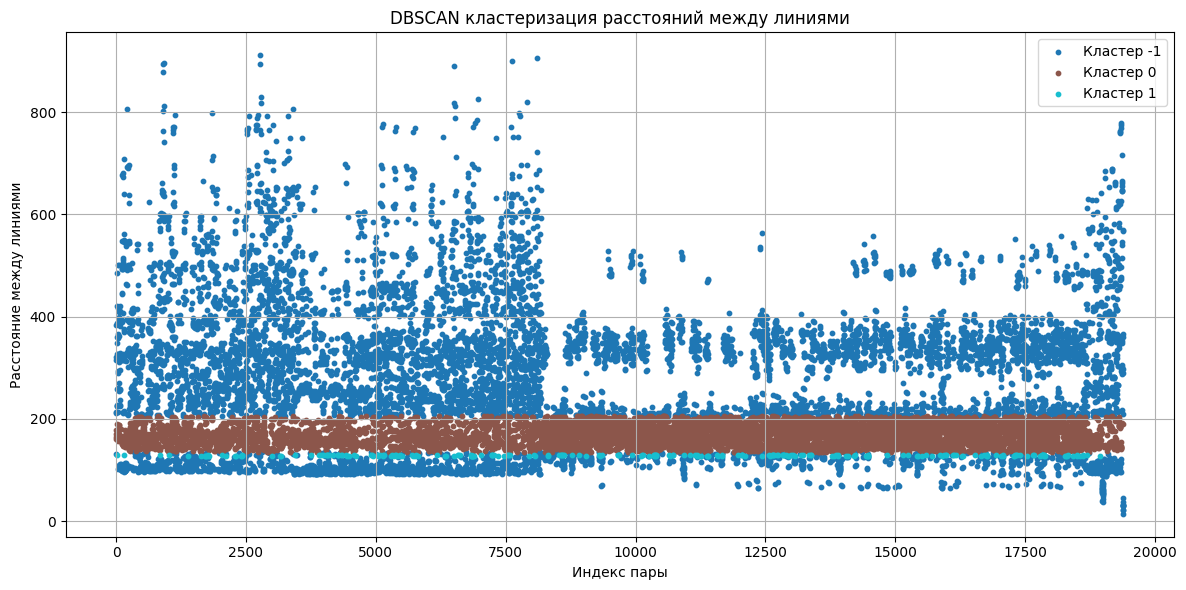

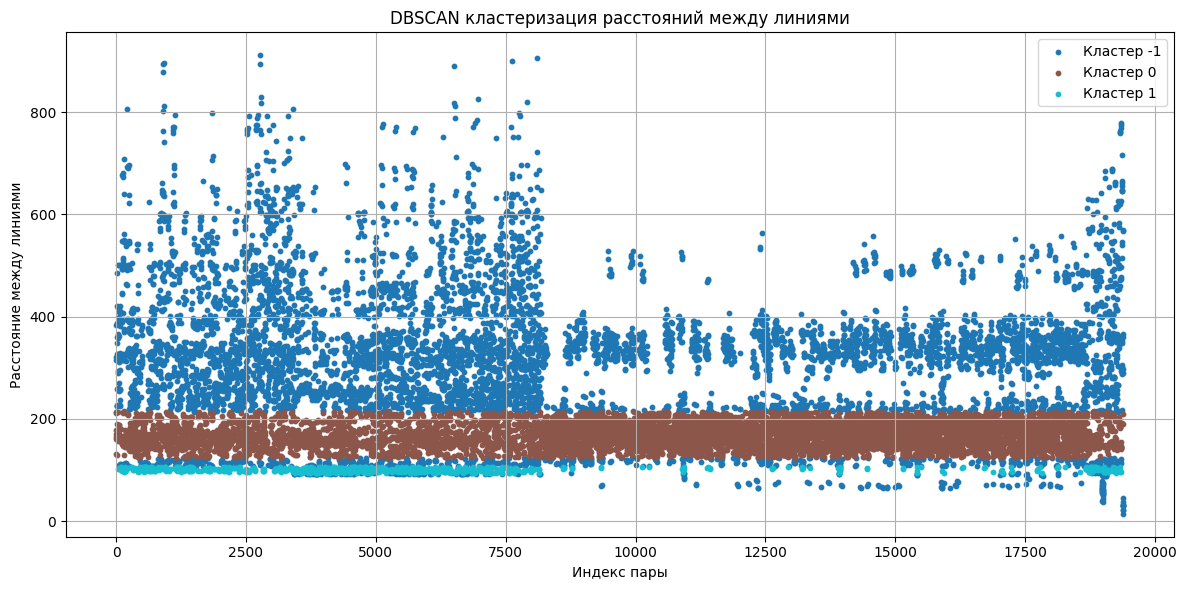

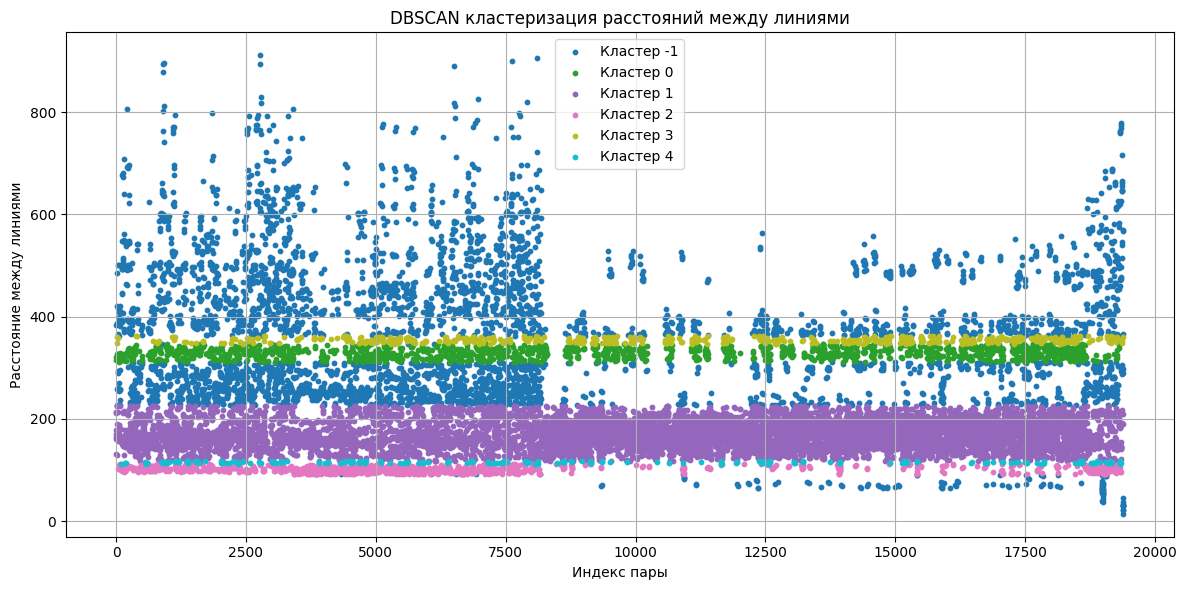

Найден оптимальный eps: 2.0
Кластеры: 115.05 и 169.26
Соотношение: 0.68 (цель: 0.67)
a1 = 115.04581458572036, a2 = 169.25954480508202, eps = 2.0


In [248]:
a1, a2, E = find_optimal_eps(dists, min_samples=min_samples)
print(f"a1 = {a1}, a2 = {a2}, eps = {E}")

# Теперь найдем сами карточки (т.е. пересечения перпендикулярных кластеров)

In [249]:
def point_side_of_line(p, a, b):
    return np.sign((b[0] - a[0])*(p[1] - a[1]) - (b[1] - a[1])*(p[0] - a[0]))
    
def is_segment_inside_strip(a, b, c):
    # a, b, c — отрезки вида [(x1, y1), (x2, y2)]
    a1, a2 = (a[0], a[1]), (a[2], a[3])
    b1, b2 = (b[0], b[1]), (b[2], b[3]) 
    c1, c2 = (c[0], c[1]), (c[2], c[3])

    side_c1_a = point_side_of_line(c1, a1, a2)
    side_c2_a = point_side_of_line(c2, a1, a2)

    side_c1_b = point_side_of_line(c1, b1, b2)
    side_c2_b = point_side_of_line(c2, b1, b2)

    if side_c1_a != side_c2_a or side_c1_b != side_c2_b:
        return False

    return side_c1_a != side_c1_b and side_c2_a != side_c2_b

In [250]:
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if abs(denom) < 1e-6:
        return None

    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
    return np.array([px, py])

In [251]:
def mark_best_perp_intersections(img, G1, G2, angle_tolerance=10):
    img_copy = img.copy()
    radius = 6

    G1_lines = G1['lines']
    G2_lines = G2['lines']

    for i in range(len(G1_lines)):
        for j in range(i + 1, len(G1_lines)):
            a = G1_lines[i]
            b = G1_lines[j]
            best = None
            min_sum = float('inf')

            for c in G2_lines:
                ca_d1 = point_to_line_distance(a, (c[0], c[1]))
                ca_d2 = point_to_line_distance(a, (c[2], c[3]))
                cb_d1 = point_to_line_distance(b, (c[0], c[1]))
                cb_d2 = point_to_line_distance(b, (c[2], c[3]))

                ca = min(ca_d1, ca_d2)
                cb = min(cb_d1, cb_d2)

                c_size = pdistance((c[0], c[1]), (c[2], c[3]))

                # ABABABAB
                ab_dist = line_to_line_distance(a, b, angle_tolerance=angle_tolerance)
                

                if not ((ca <= (ab_dist*1.1 - c_size)) and
                        (cb <= (ab_dist*1.1 - c_size))):
                    # print(f"POPALSA!")
                    continue
                    
                # if not ((ca <= max(a1, a2)*1.1 - c_size) and
                #         (cb <= max(a2, a2)*1.1 - c_size)):
                #     # print(f"POPALSA!")
                #     continue

                # STRIP STRIP
                if not is_segment_inside_strip(c, a, b):
                    continue
                # STRIP STRIP
                
                # lets find out the exact p of start for both
                a_d1 = point_to_line_distance(c, (a[0], a[1]))
                a_d2 = point_to_line_distance(c, (a[2], a[3]))
                b_d1 = point_to_line_distance(c, (b[0], b[1]))
                b_d2 = point_to_line_distance(c, (b[2], b[3]))

                if a_d1 < a_d2:
                    a_start = (a[0], a[1])
                else:
                    a_start = (a[2], a[3])
                    
                if b_d1 < b_d2:
                    b_start = (b[0], b[1])
                else:
                    b_start = (b[2], b[3])

                #
                
                # if not ((a_d1 > 1 and a_d2 > 1) and (b_d1 > 1 and b_d2 > 1)):
                #     print(f"SHIT HAPPEND: {a_d1} or {a_d2} or {b_d1} or {b_d2}")
                
                m1 = line_intersection(a, c)
                m2 = line_intersection(b, c)
                
                if m1 is None or m2 is None:
                    print(f"NO INTER: {m1}, {m2}")
                    continue

                dist1 = pdistance(m1, a_start)
                dist2 = pdistance(m2, b_start)

                #####
                if not ((dist1 <= max(a1, a2)*1.1) and
                        (dist2 <= max(a1, a2)*1.1)):
                    continue
                    
                m1m2 = pdistance(m1, m2)
                
                if not (min(a1, a2)*0.7 <= m1m2 <= max(a1, a2)*1.3):
                    continue
                if not (ab_dist*0.95 <= m1m2 <= ab_dist*1.05):
                    continue
                
                m1 = tuple(map(int, m1))
                m2 = tuple(map(int, m2))
                cv2.circle(img_copy, m1, radius, (0, 255, 0), -1)
                cv2.circle(img_copy, m2, radius, (255, 0, 0), -1)
                cv2.line(img_copy, m1, m2, (0, 0, 255), 5)
                # cv2.line(img_copy, a_start, m1, (100, 0, 255), 5)
                # cv2.line(img_copy, b_start, m2, (100, 0, 255), 5)
                
                  
                #####
#                 score = dist1 + dist2
#                 if score < min_sum:
#                     min_sum = score
#                     best = (m1, m2)
# 
#             if best:
#                 m1, m2 = best
#                 m1 = tuple(map(int, m1))
#                 m2 = tuple(map(int, m2))
#                 cv2.circle(img_copy, m1, radius, (0, 255, 0), -1)
#                 cv2.circle(img_copy, m2, radius, (255, 0, 0), -1)
#                 cv2.line(img_copy, m1, m2, (0, 0, 255), 5)
#                 # cv2.line(img_copy, a_start, m1, (100, 0, 255), 5)
#                 # cv2.line(img_copy, b_start, m2, (100, 0, 255), 5)
                
    return img_copy

In [252]:
output = img.copy()

for i, G1 in enumerate(clusters):
    for j, G2 in enumerate(clusters):
        if i >= j:
            continue

        angle1 = G1['angle']
        angle2 = G2['angle']
        angle_diff = abs((angle1 - angle2 + 180) % 180 - 90)

        # +- ANGANGLE_TOLERANCE
        if angle_diff <= ANGLE_TOLERANCE: 
            print(f"[DEBUG] G1 #{i} (angle={angle1:.2f}) ⟂ G2 #{j} (angle={angle2:.2f})")
            output = mark_best_perp_intersections(output, G1, G2, angle_tolerance=ANGLE_TOLERANCE)

[DEBUG] G1 #0 (angle=87.90) ⟂ G2 #2 (angle=-1.65)


KeyboardInterrupt: 

In [ ]:
see(output)